In [3]:
# ========== IMPORTS ==========
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
# from google.colab import files
from tensorflow.keras import Model, Input
from tensorflow.keras.applications import ResNet50, EfficientNetV2B0, ConvNeXtTiny
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, RandomZoom, RandomContrast, RandomRotation, Lambda
from tensorflow.keras.regularizers import l1
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import load_model
import shutil

In [1]:
best_convnext_path = "./results_AUG_30/ConvNeXtTiny_lr0.0005_bs128_do0.5_l10.0_augcontrast_fsfull.keras"
best_resnet_path = "./results_LR/ResNet50_lr0.0003_bs128_do0.5_l10.0_augnone_fsfull.keras"
best_efficientnet_path = "./results_LR/EfficientNetV2B0_lr0.0005_bs128_do0.5_l10.0_augnone_fsfull.keras"

In [4]:
# ========== CONFIG ==========
EPOCHS = 10
IMAGE_SIZE = (32, 32)
NUM_CLASSES = 10
LEARNING_RATES = [5e-4] #5e-4 - 1e-4, 3e-4, 1e-3
BATCH_SIZES = [128] #128 - 32 ,64, 128
DROPOUT_RATES = [0.5] #0.5 - 0.3, 0.5, 0.7
L1_REGS = [0.0] #0.0 - 0.0, 1e-5, 1e-4
AUGMENT_TYPES = ['none'] #'none' - 'none', 'rotation', 'contrast', 'zoom', 'cutmix'
FEW_SHOT_ENABLED = False
FEW_SHOT_SAMPLES_PER_CLASS = [10, 50, 200]

DATASET_PATH = "./content/cinic10"
TRAIN_DIR = DATASET_PATH + "/train"
VALID_DIR = DATASET_PATH + "/valid"
TEST_DIR = DATASET_PATH + "/test"
RESULTS_DIR = "./content/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
# convnext_custom_objects = {"preprocess_input": convnext_preprocess}
# efficientnet_custom_objects = {"preprocess_input": efficientnet_preprocess}
# resnet_custom_objects = {"preprocess_input": resnet_preprocess}

# model1 = load_model("./results_L1/ConvNeXtTiny_lr0.0005_bs128_do0.5_l10.0_augnone_fsfull.keras", custom_objects=convnext_custom_objects)
# model2 = load_model("./results_L1/ResNet50_lr0.0005_bs128_do0.5_l10.0001_augnone_fsfull.keras", custom_objects=resnet_custom_objects)
# model3 = load_model("./results_L1/ConvNeXtTiny_lr0.0005_bs128_do0.5_l11e-05_augnone_fsfull.keras", custom_objects=convnext_custom_objects)

# trained_models = [model1, model2, model3]


In [ ]:
convnext_custom_objects = {"preprocess_input": convnext_preprocess}
efficientnet_custom_objects = {"preprocess_input": efficientnet_preprocess}
resnet_custom_objects = {"preprocess_input": resnet_preprocess}

model1 = load_model(best_convnext_path, custom_objects=convnext_custom_objects)
model2 = load_model(best_resnet_path, custom_objects=resnet_custom_objects)
model3 = load_model(best_efficientnet_path, custom_objects=convnext_custom_objects)

trained_models = [model1, model2, model3]


In [7]:
from scipy.stats import mode
test_ds = image_dataset_from_directory(TEST_DIR, image_size=IMAGE_SIZE, batch_size=64, label_mode='categorical', shuffle=False, seed=123)
X_test, y_true = [], []
for images, labels in test_ds:
    X_test.append(images)
    y_true.append(labels)
X_test = tf.concat(X_test, axis=0)
y_true = tf.concat(y_true, axis=0)
y_true_labels = tf.argmax(y_true, axis=1).numpy()



Found 90000 files belonging to 10 classes.


Hard Voting Accuracy: 63.23%
Soft Voting Accuracy: 67.30%
Stacking Accuracy: 67.85%


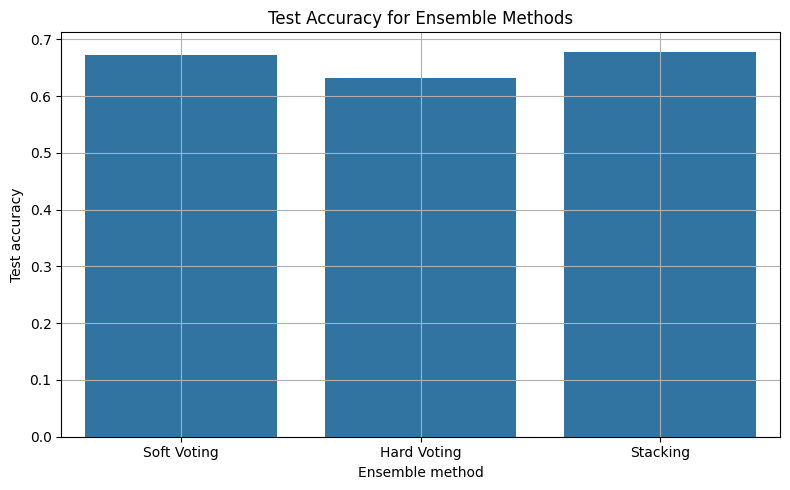

In [ ]:
# ========== ENSEMBLING ==========
predictions = np.array([model.predict(X_test) for model in trained_models])

hard_voting_preds = mode(np.argmax(predictions, axis=2), axis=0)[0].flatten()
soft_voting_preds = np.argmax(np.mean(predictions, axis=0), axis=1)

# Stack Voting (Meta-Learner using Logistic Regression)
stacked_features = np.hstack([pred.reshape(pred.shape[0], -1) for pred in predictions])

meta_learner = LogisticRegression(max_iter=1000, multi_class='multinomial')
meta_learner.fit(stacked_features, y_true_labels)
stack_voting_preds = meta_learner.predict(stacked_features)

hard_voting_acc = accuracy_score(y_true_labels, hard_voting_preds)
soft_voting_acc = accuracy_score(y_true_labels, soft_voting_preds)
stack_voting_acc = accuracy_score(y_true_labels, stack_voting_preds)

print(f"Hard Voting Accuracy: {hard_voting_acc * 100:.2f}%")
print(f"Soft Voting Accuracy: {soft_voting_acc * 100:.2f}%")
print(f"Stacking Accuracy: {stack_voting_acc * 100:.2f}%")

ensemble_df = pd.DataFrame({
    'method': ['Soft Voting', 'Hard Voting', 'Stacking'],
    'val_accuracy': [soft_voting_acc, hard_voting_acc, stack_voting_acc]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=ensemble_df, x='method', y='val_accuracy')
plt.ylabel("Test accuracy")
plt.xlabel("Ensemble method")
plt.title("Test Accuracy for Ensemble Methods")
plt.grid()
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/final_plot_ensembles.png")
plt.show()

ensemble_df.to_csv(os.path.join(RESULTS_DIR, "ensemble_results.csv"), index=False)